# Group Submission 2
---
## Team Members:
- Neo Meng Hwee
- Marc Tan
- Kanwar Angad Singh Dusaj
- Kim Chuong Hoang

---

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

## Question
- Select at least four explanatory variables and perform the necessary transformations
so that they are useful in the model phase. You are encouraged to use more than four
variables. Investigate feature engineering techniques such as PCA and encoding
target variables using one-hot encoding
- Write a short paragraph about each technique investigated and show an
implementation of it in a Jupyter Notebook. Make sure to include references that
indicate where the ideas were sourced

### Generating Variables

- we will use the data from the **`data_day`** file generated from Submission 1 for this exercise



#### Importing Into DataFrame

In [4]:
import pandas as pd 
import numpy as np

data = pd.read_csv('data_day.csv', parse_dates=True, index_col='Date_Time')

#### Generating `close` variable

- period close price

In [5]:
data.drop(columns=['open', 'low', 'high', 'volume'], inplace=True)
data.head()

,close
Date_Time,
2013-09-01 17:00:00,1640.25
2013-09-01 17:05:00,1640.50
2013-09-01 17:10:00,1640.50
2013-09-01 17:15:00,1640.75
2013-09-01 17:20:00,1640.50


#### Generating `MACD` & `MACDSignal` variables

- Moving average convergence / divergence value
- MACD signal

In [6]:
data['EMA12'] = 0
data['EMA26'] = 0
data['EMA12'] = data['close'].ewm(min_periods=12,halflife=48,adjust=False).mean()
data['EMA26'] = data['close'].ewm(min_periods=26,halflife=104,adjust=False).mean()

data['MACD'] = (data['EMA12'] - data['EMA26'])
data['MACDsignal'] = data['MACD'].ewm(min_periods=9,halflife=36,adjust=False).mean()

data.drop(columns=['EMA12', 'EMA26'], inplace=True)
data.tail()

,close,MACD,MACDsignal
Date_Time,,,
2013-09-20 15:55:00,1704.50,-2.776568,-1.204074
2013-09-20 16:00:00,1704.75,-2.796478,-1.234441
2013-09-20 16:05:00,1704.75,-2.815707,-1.264596
2013-09-20 16:10:00,1704.00,-2.840036,-1.294640
2013-09-20 16:15:00,1703.75,-2.865510,-1.324596


#### Generating `pct_change` & `RSI` variables

- Percent change increase - `True / False`
- Relative strength index


In [7]:
data['pct_change'] = data['close'].pct_change()
data['pct_change'] = np.where(data['pct_change']>=0, 1, 0)
data['up'] = data['pct_change']
data['up'].fillna(0)
data['up'] = np.where(data['up']>0, 1, 0)
data['down'] = data['pct_change']
data['down'].fillna(0)
data['down'] = np.where(data['down']<=0, 1, 0)
data['RSIup'] = data['up'].ewm(min_periods=14,halflife=56,adjust=False).mean()
data['RSIdown'] = data['down'].ewm(min_periods=14,halflife=56,adjust=False).mean()
data['RS'] = data['RSIup'] / data['RSIdown']
data['RSI']= 100.0 - (100.0 / (1.0 + data['RS']))

data.drop(columns=['up', 'down', 'RSIup', 'RSIdown', 'RS'], inplace=True)
data.tail()

,close,MACD,MACDsignal,pct_change,RSI
Date_Time,,,,,
2013-09-20 15:55:00,1704.50,-2.776568,-1.204074,1,59.732475
2013-09-20 16:00:00,1704.75,-2.796478,-1.234441,1,60.227820
2013-09-20 16:05:00,1704.75,-2.815707,-1.264596,1,60.717071
2013-09-20 16:10:00,1704.00,-2.840036,-1.294640,0,59.970170
2013-09-20 16:15:00,1703.75,-2.865510,-1.324596,0,59.232456


#### Generating `close_autocorrel`, `pearsonr_close_MACD` and `pearsonr_close_RSI` variables

- Autocorrelation on period close price
- Correlation period close price vs MACD
- Correlation period close price vs RSI

In [8]:
from scipy.stats.stats import pearsonr

autocorrel = []
data['close_autocorrel'] = ''
data['pearsonr_close_MACD'] = ''
data['pearsonr_close_RSI'] = ''
data['quartile'] = 0
quarter = int(len(data) / 4)
for i in range (0,29):
    autocorrel.append('')
    data.iloc[i, data.columns.get_loc('quartile')] = int((i - 1) / quarter) + 1
for i in range(29,len(data)):
    seq1 = []
    seq2 = []
    seq3 = []
    quartile_val = int((i - 1) / quarter) + 1
    if (quartile_val == 5):
        quartile_val = 4
    data.iloc[i, data.columns.get_loc('quartile')] = quartile_val
    #print(i, quarter, quartile_val)
    for j in range (i-28,i):
        seq1.append(data['close'][j])
        seq2.append(data['MACD'][j])
        seq3.append(data['RSI'][j])
    autocorrel_series = pd.Series(seq1)
    autocorrel_val = autocorrel_series.autocorr(lag=1)
    data.iloc[i, data.columns.get_loc('close_autocorrel')] = autocorrel_val
    autocorrel.append(autocorrel_val)
    cross_correlation = pearsonr(seq1, seq2)
    data.iloc[i, data.columns.get_loc('pearsonr_close_MACD')] = cross_correlation[0]
    cross_correlation = pearsonr(seq1, seq3)
    data.iloc[i, data.columns.get_loc('pearsonr_close_RSI')] = cross_correlation[0]
    data.tail()

In [9]:
data.tail()

,close,MACD,MACDsignal,pct_change,RSI,close_autocorrel,pearsonr_close_MACD,pearsonr_close_RSI,quartile
Date_Time,,,,,,,,,
2013-09-20 15:55:00,1704.50,-2.776568,-1.204074,1,59.732475,0.88251,0.78316,0.884687,4
2013-09-20 16:00:00,1704.75,-2.796478,-1.234441,1,60.227820,0.866933,0.715724,0.869826,4
2013-09-20 16:05:00,1704.75,-2.815707,-1.264596,1,60.717071,0.871859,0.631796,0.869516,4
2013-09-20 16:10:00,1704.00,-2.840036,-1.294640,0,59.970170,0.869695,0.57301,0.860855,4
2013-09-20 16:15:00,1703.75,-2.865510,-1.324596,0,59.232456,0.86105,0.535243,0.84871,4


#### Submission 3

1.Decide on an algorithm or group of algorithms (for example, ensemble techniques).

2 Fit the model.

3 Show that it works out of sample, and use appropriate cross-validation techniques.

4 Provide the following performance metrics:

(a) ROC curves,

(b) Confusion Matrix,

(c) Precision, Recall, F1-Score, Accuracy, and AUC.

5 Analysis of metrics and report.

In [10]:
data.dropna(thresh=9,inplace=True)
data.columns

Index(['close', 'MACD', 'MACDsignal', 'pct_change', 'RSI', 'close_autocorrel',
       'pearsonr_close_MACD', 'pearsonr_close_RSI', 'quartile'],
      dtype='object')

In [11]:
X = data[['close','MACD','MACDsignal','RSI','close_autocorrel','pearsonr_close_MACD','pearsonr_close_RSI','quartile']] #This includes everything
#data['Returns']= data['Price'].shift(-1)-data['Price'].shift(-2)
#Y = data['Returns']
Y = data['pct_change']
X

,close,MACD,MACDsignal,RSI,close_autocorrel,pearsonr_close_MACD,pearsonr_close_RSI,quartile
Date_Time,,,,,,,,
2013-09-01 21:25:00,1641.50,0.336070,0.153981,33.400392,0.750125,0.503486,0.651683,1
2013-09-01 21:30:00,1641.00,0.334070,0.157416,32.989523,0.678677,0.327196,0.492914,1
2013-09-01 21:35:00,1640.75,0.330155,0.160710,32.583707,0.676926,0.0935135,0.279787,1
2013-09-01 21:40:00,1641.00,0.328215,0.163904,33.413018,0.738352,-0.0947716,0.108066,1
2013-09-01 21:45:00,1641.00,0.326284,0.167001,34.232127,0.771034,-0.234317,-0.0355287,1
2013-09-01 21:50:00,1640.75,0.322439,0.169965,33.811026,0.80199,-0.362552,-0.184292,1
2013-09-01 21:55:00,1641.00,0.320567,0.172837,34.625239,0.827196,-0.445928,-0.284746,1
2013-09-01 22:00:00,1641.00,0.318703,0.175618,35.429437,0.845173,-0.52216,-0.382126,1
2013-09-01 22:05:00,1641.00,0.316848,0.178312,36.223741,0.859334,-0.564104,-0.447319,1


In [12]:
#create training and testing data sets
test_size = 0.2
X_train = X[:-int(test_size*len(X))]
X_test = X[-int(test_size*len(X)):]
y_train = Y[:-int(test_size*len(X))]
y_test = Y[-int(test_size*len(X)):]

In [13]:
from sklearn.preprocessing import StandardScaler
#scale data
scaler = StandardScaler()
scaler.fit(X_train) #only fit to training set
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  """
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  


In [14]:
# Try neural network - MLPRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
mlp = MLPRegressor(hidden_layer_sizes=(13,13,13), max_iter=500, learning_rate='adaptive',verbose=10,activation='relu',solver='adam',alpha=0.0001,random_state=0)
mlp.fit(X_train, y_train)
print ("Training Score: ", mlp.score(X_train, y_train))
print ("Test Score: ", mlp.score(X_test, y_test))

Iteration 1, loss = 0.56158963
Iteration 2, loss = 0.26659762
Iteration 3, loss = 0.17575221
Iteration 4, loss = 0.14753389
Iteration 5, loss = 0.13165051
Iteration 6, loss = 0.12313023
Iteration 7, loss = 0.11894275
Iteration 8, loss = 0.11714942
Iteration 9, loss = 0.11601094
Iteration 10, loss = 0.11518908
Iteration 11, loss = 0.11437869
Iteration 12, loss = 0.11387643
Iteration 13, loss = 0.11348476
Iteration 14, loss = 0.11311474
Iteration 15, loss = 0.11282103
Iteration 16, loss = 0.11257470
Iteration 17, loss = 0.11238446
Iteration 18, loss = 0.11211320
Iteration 19, loss = 0.11195119
Iteration 20, loss = 0.11177628
Iteration 21, loss = 0.11152130
Iteration 22, loss = 0.11145626
Iteration 23, loss = 0.11133055
Iteration 24, loss = 0.11116319
Iteration 25, loss = 0.11114542
Iteration 26, loss = 0.11098898
Iteration 27, loss = 0.11091079
Iteration 28, loss = 0.11075999
Iteration 29, loss = 0.11104888
Iteration 30, loss = 0.11066750
Iteration 31, loss = 0.11047814
Iteration 32, los

In [15]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
rf_clf = RandomForestRegressor(n_estimators = 100)
rf_clf.fit(X_train,y_train)

print ("Training Score: ", rf_clf.score(X_train, y_train))
print ("Test Score: ", rf_clf.score(X_test, y_test))

Training Score:  0.8633679139111483
Test Score:  -0.05596602049015664


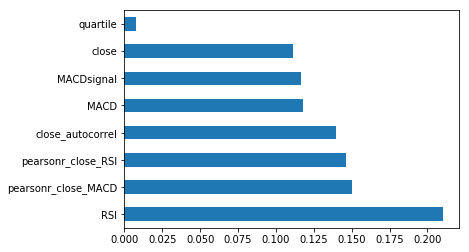

In [20]:
from matplotlib import pyplot as plt
#Feature Extraction based on the RF fitted model.
feat_importances = pd.Series(rf_clf.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

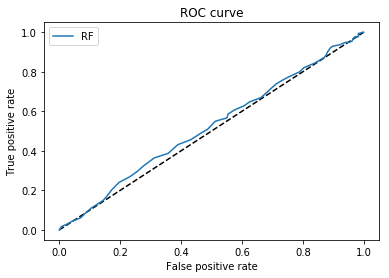

In [21]:
from sklearn.metrics import roc_curve, classification_report

y_pred = rf_clf.predict(X_test)

fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
def get_model(trainX, trainy):
# define model
    model = Sequential()
    model.add(Dense(100, input_dim=8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
# compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
    model.fit(trainX, trainy, epochs=300, verbose=0)
    return model

# fit model
model = get_model(X_train, y_train)


W1006 17:10:00.876435  1236 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1006 17:10:00.892366  1236 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1006 17:10:00.895378  1236 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1006 17:10:00.921289  1236 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1006 17:10:00.940269  1236 deprecation_wrapper.py:119] From C:\Users\user\Anaconda3

In [24]:
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
def get_model(trainX, trainy):
# define model
    model = Sequential()
    model.add(Dense(100, input_dim=8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
# compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# fit model
    model.fit(trainX, trainy, epochs=300, verbose=0)
    return model

# fit model
model = get_model(X_train, y_train)


In [25]:
#************************Precision, Recall, F1-Score, Accuracy, and AUC.

# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = model.predict_classes(X_test, verbose=0)

In [31]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_test, yhat_classes)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_test, yhat_classes)
print('F1 score: %f' % f1)

# ROC AUC
auc = roc_auc_score(y_test, yhat_probs)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
print(matrix)


Accuracy: 0.641533
Precision: 0.653141
Recall: 0.952290
F1 score: 0.774845
ROC AUC: 0.581900
[[ 20 265]
 [ 25 499]]


In [35]:
returns = y_pred - y_test
print (returns)

Date_Time
2013-09-17 19:05:00   -0.63
2013-09-17 19:10:00   -0.40
2013-09-17 19:15:00   -0.08
2013-09-17 19:20:00    0.85
2013-09-17 19:25:00   -0.14
2013-09-17 19:30:00    0.84
2013-09-17 19:35:00   -0.15
2013-09-17 19:40:00   -0.17
2013-09-17 19:45:00    0.88
2013-09-17 19:50:00   -0.17
2013-09-17 19:55:00   -0.18
2013-09-17 20:00:00   -0.14
2013-09-17 20:05:00   -0.13
2013-09-17 20:10:00    0.86
2013-09-17 20:15:00   -0.12
2013-09-17 20:20:00   -0.12
2013-09-17 20:25:00   -0.15
2013-09-17 20:30:00   -0.14
2013-09-17 20:35:00   -0.10
2013-09-17 20:40:00   -0.11
2013-09-17 20:45:00    0.82
2013-09-17 20:50:00   -0.15
2013-09-17 20:55:00   -0.11
2013-09-17 21:00:00   -0.13
2013-09-17 21:05:00   -0.13
2013-09-17 21:10:00   -0.19
2013-09-17 21:15:00   -0.20
2013-09-17 21:20:00    0.83
2013-09-17 21:25:00   -0.23
2013-09-17 21:30:00   -0.23
                       ... 
2013-09-20 13:40:00   -0.39
2013-09-20 13:45:00   -0.43
2013-09-20 13:50:00   -0.37
2013-09-20 13:55:00   -0.40
2013-09-20

Start date,2013-09-17
End date,2013-09-20
Total months,38
,Backtest
Annual return,-100.0%
Cumulative returns,-100.0%
Annual volatility,778.0%
Sharpe ratio,1.05
Calmar ratio,-1.00
Stability,0.93
Max drawdown,-100.0%


C:\Users\user\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,100.00,2013-09-18,2013-09-19,NaT,NaN
1,91.87,2013-09-18,2013-09-18,2013-09-18,1
2,85.89,2013-09-17,2013-09-17,2013-09-18,1
3,78.97,2013-09-18,2013-09-18,2013-09-18,1
4,77.57,2013-09-18,2013-09-18,2013-09-18,1


C:\Users\user\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Stress Events,mean,min,max
New Normal,3.23%,-72.00%,92.00%


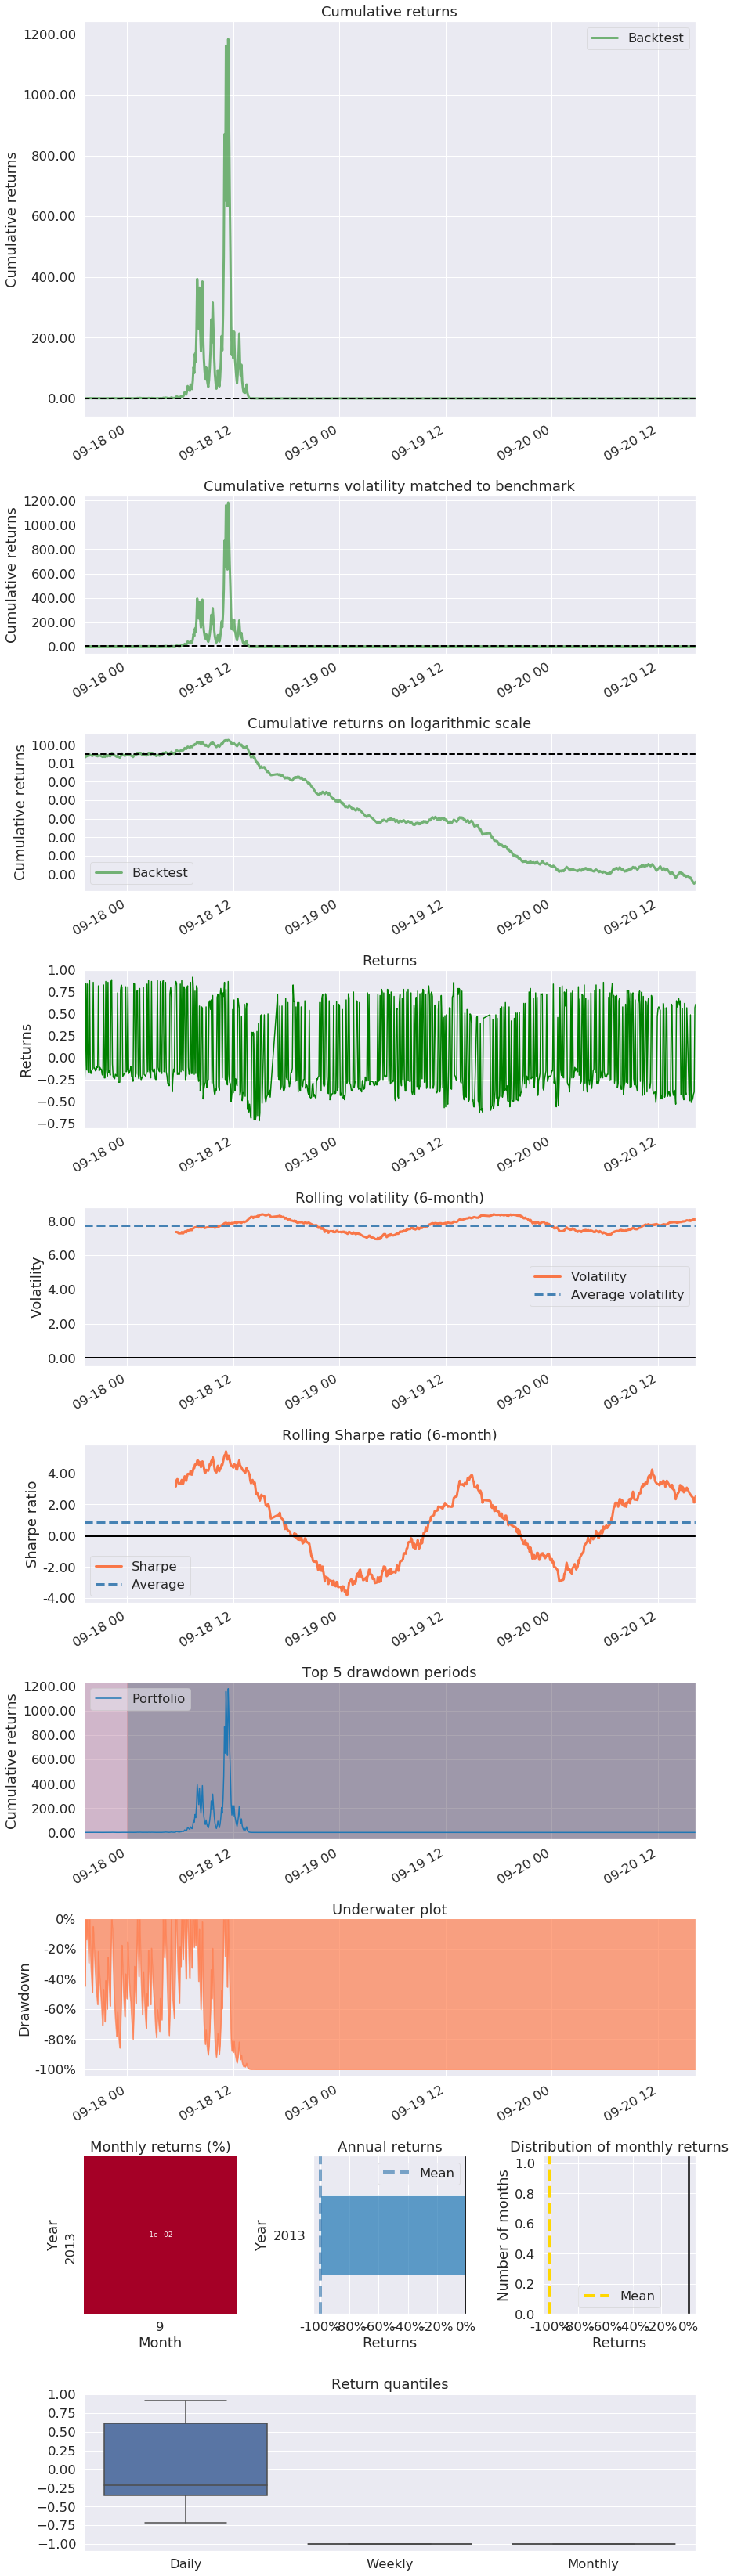

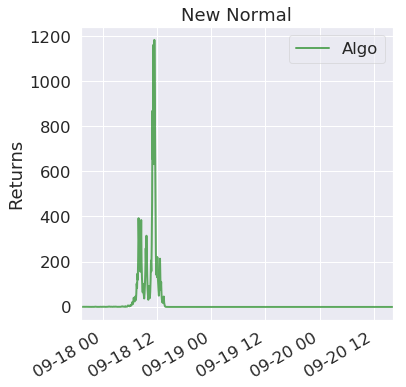

In [36]:
import pyfolio as pf
from pyfolio import timeseries 
yhat_probs
#perf_func = timeseries.perf_stats 
#perf_stats_all = perf_func(returns=your_portfolio_returns_as_a_pdSeries, factor_returns=your_benchmark_returns_as_a_pdSeries, positions=None, transactions=None, turnover_denom="AGB")
pf.create_full_tear_sheet(returns)